In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import re
from collections import defaultdict
from datetime import datetime
import numpy as np
import matplotlib.cm as cm
from matplotlib.colors import PowerNorm
# Load the data
df = pd.read_csv("../data/every_map.csv")

# Helper: extract clean team name (no parentheses)
def clean_name(name_with_score):
    return re.sub(r'\s*\(.*?\)', '', name_with_score)#.lower().strip()

# Clean names
df["Team1_Clean"] = df["Team1_Text"].apply(clean_name)
df["Team2_Clean"] = df["Team2_Text"].apply(clean_name)

# Convert date to datetime
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
# astralis = "Ninjas in Pyjamas"
# Function to build domination graph for Astralis for a given time range
def build_domination_graph(df,astralis, start_year, end_year):
    # Filter for the date range
    df_range = df[(df["Date"].dt.year >= start_year) & (df["Date"].dt.year <= end_year)]
    
    # Create a dictionary to store total wins for each team (including Astralis)
    total_wins = defaultdict(int)
    total_losses = defaultdict(int)
    # Count wins for all teams in the time period
    for _, row in df_range.iterrows():
        t1, t2 = row["Team1_Clean"], row["Team2_Clean"]
        s1, s2 = row["Team1_Score"], row["Team2_Score"]
        
        if s1 > s2:
            total_wins[t1] += 1
            total_losses[t2] += 1
        elif s2 > s1:
            total_wins[t2] += 1
            total_losses[t1] += 1
    
    # Only games involving Astralis
    df_astralis = df_range[
        (df_range["Team1_Clean"] == astralis) | (df_range["Team2_Clean"] == astralis)
    ]

    matchups = defaultdict(lambda: {"maps": [0, 0], "rounds": [0, 0]})  # team -> [maps_won, rounds_won]

    for _, row in df_astralis.iterrows():
        t1, t2 = row["Team1_Clean"], row["Team2_Clean"]
        s1, s2 = row["Team1_Score"], row["Team2_Score"]

        # Identify opponent and who won
        if t1 == astralis:
            opponent = t2
            if s1 > s2:
                matchups[opponent]["maps"][0] += 1  # Astralis win
            elif s1 < s2:
                matchups[opponent]["maps"][1] += 1
            matchups[opponent]["rounds"][0] += s1
            matchups[opponent]["rounds"][1] += s2
        elif t2 == astralis:
            opponent = t1
            if s2 > s1:
                matchups[opponent]["maps"][0] += 1  # Astralis win
            elif s2 < s1:
                matchups[opponent]["maps"][1] += 1
            matchups[opponent]["rounds"][0] += s2
            matchups[opponent]["rounds"][1] += s1

    # Build graph
    G = nx.DiGraph()

    for opponent, stats in matchups.items():
        astralis_maps, opp_maps = stats["maps"]
        astralis_rounds, opp_rounds = stats["rounds"]

        # Add nodes with size attribute based on total wins
        G.add_node(astralis, size=total_wins.get(astralis, 1))
        G.add_node(opponent, size=total_wins.get(opponent, 1))

        if astralis_maps > opp_maps:
            G.add_edge(astralis, opponent, weight=astralis_maps - opp_maps)
        elif opp_maps > astralis_maps:
            G.add_edge(opponent, astralis, weight=opp_maps - astralis_maps)
        else:
            G.add_edge(astralis, opponent, weight=0.5)
            G.add_edge(opponent, astralis, weight=0.5)
            # tie in maps, go by rounds
            # if astralis_rounds > opp_rounds:
            #     G.add_edge("FURIA", opponent, weight=0.5)
            # elif opp_rounds > astralis_rounds:
            #     G.add_edge(opponent, "Astralis", weight=0.5)
            # If even rounds too, no edge
            
    cmap = plt.cm.cool  # reversed: red = low, green = high
    # cmap = plt.cm.spring
    norm = PowerNorm(gamma=0.7, vmin=0, vmax=1)  
  
    node_colors = {node:cmap(norm(total_wins.get(node,0)/(total_losses[node]+total_wins[node]))) for node in G.nodes()}
    return G, node_colors

# Build both graphs


def custom_astralis_layout(G,astralis, dominated_places=(np.pi,0), dominated_by_places=(4*np.pi/3, 5*np.pi/3), tied_places=(np.pi/32, -np.pi/32)):
    center = astralis
    pos = {center: np.array([0.0, 0.0])}

    dominated = []
    dominated_by = []
    tied = []

    for node in G.nodes():
        if node == center:
            continue
        
        astralis_edge = G.get_edge_data(center, node)
        reverse_edge = G.get_edge_data(node, center)
        
        if astralis_edge and not reverse_edge:
            dominated.append(node)
        elif reverse_edge and not astralis_edge:
            dominated_by.append(node)
        elif astralis_edge and reverse_edge:
            tied.append(node)

    # Sort by node size (larger to smaller)
    dominated.sort(key=lambda n: G.nodes[n]['size'], reverse=True)
    dominated_by.sort(key=lambda n: G.nodes[n]['size'], reverse=True)
    tied.sort(key=lambda n: G.nodes[n]['size'], reverse=True)

    radius = 3

    def place_nodes(nodes, start_angle, end_angle):
        n = len(nodes)
        if n == 0:
            return
        angles = np.linspace(start_angle, end_angle, n)
        label_offsets = {}

        for angle, node in zip(angles, nodes):
            x = radius * np.cos(angle)
            y = radius * np.sin(angle)
            pos[node] = np.array([x, y])

    # Place dominated teams on the RIGHT (−π/2 to π/2)
    place_nodes(dominated, dominated_places[0], dominated_places[1])

    # Place dominating teams on the LEFT (2π/3 to 4π/3)
    place_nodes(dominated_by, dominated_by_places[0], dominated_by_places[1])

    # Place tied teams on the BOTTOM (5π/4 to 7π/4)
    place_nodes(tied, tied_places[0], tied_places[1])

    return pos

def draw_graph(G,team, nodecolors, title, dominated_places=(np.pi,0), dominated_by_places=(4*np.pi/3, 5*np.pi/3), tied_places=(np.pi/32, -np.pi/32)):
    print(nodecolors)
    pos = custom_astralis_layout(G,team, dominated_places=dominated_places, dominated_by_places=dominated_by_places, tied_places=tied_places)
    weights = [G[u][v]["weight"] for u, v in G.edges()]
    node_sizes = [G.nodes[node]['size'] * 8 for node in G.nodes()]
    
    # Normalize font sizes for nodes
    font_sizes = {node: min(28, max(12, G.nodes[node]['size'] * 1)) for node in G.nodes()}
    
    # Normalize font sizes for edges
    edge_font_sizes = { (u, v): min(28, max(12, G[u][v]['weight'] * 1.2)) for u, v in G.edges() }

    plt.figure(figsize=(20,20))
    
    # Draw nodes and edges
    nx.draw(G, pos, node_color="black", edge_color=weights,
            edge_cmap=plt.cm.RdYlGn, width=2,#width=[2 + w for w in weights],
            # node_size=node_sizes,
            node_size=0,
            arrows=True, arrowstyle='->', arrowsize=15)

    node_id = 0

    # Draw node labels with individual font sizes
    for node, (x, y) in pos.items():
        # Calculate angle from center
        angle = np.arctan2(y, x)
        dx = 0.15 * np.cos(angle)
        dy = 0.15 * np.sin(angle)
        # dx,dy = 0,0
        
        r,g,b,a = nodecolors[node]
        plt.text(x + dx, y + dy, s=str(node), fontsize=font_sizes[node], ha='center', va='center',color=(r,g,b,1))
        node_id += 1
    # Draw edge labels with individual font sizes
    edge_labels = {(u, v): G[u][v]['weight'] for u, v in G.edges()}
    for (u, v), label in edge_labels.items():
        (x1, y1) = pos[u]
        (x2, y2) = pos[v]
        x, y = (x1 + x2) / 2, (y1 + y2) / 2
        plt.text(x, y, s=str(label), fontsize=edge_font_sizes[(u, v)], color='black')

    plt.title(title)
    plt.axis("off")
    plt.tight_layout()
    plt.show()





In [86]:
def custom_astralis_layout(G, astralis, dominated_places=(np.pi, 0), dominated_by_places=(4*np.pi/3, 5*np.pi/3), tied_places=(np.pi/32, -np.pi/32)):
    center = astralis
    pos = {center: np.array([0.0, 0.0])}

    dominated = []
    dominated_by = []
    tied = []

    for node in G.nodes():
        if node == center:
            continue
        
        astralis_edge = G.get_edge_data(center, node)
        reverse_edge = G.get_edge_data(node, center)
        
        if astralis_edge and not reverse_edge:
            dominated.append(node)
        elif reverse_edge and not astralis_edge:
            dominated_by.append(node)
        elif astralis_edge and reverse_edge:
            tied.append(node)

    # Sort by node size (largest first)
    dominated.sort(key=lambda n: G.nodes[n]['size'], reverse=True)
    dominated_by.sort(key=lambda n: G.nodes[n]['size'], reverse=True)
    tied.sort(key=lambda n: G.nodes[n]['size'], reverse=True)

    def place_nodes(nodes, start_angle, end_angle, radius=2.0):
        n = len(nodes)
        if n == 0:
            return
        
        # Calculate equal angular spacing
        if n == 1:
            angles = [(start_angle + end_angle)/2]
        else:
            angles = np.linspace(start_angle, end_angle, n)
        
        for angle, node in zip(angles, nodes):
            x = radius * np.cos(angle)
            y = radius * np.sin(angle)
            pos[node] = np.array([x, y])

    # Place all node groups with uniform radius
    place_nodes(dominated, dominated_places[0], dominated_places[1])
    place_nodes(dominated_by, dominated_by_places[0], dominated_by_places[1])
    place_nodes(tied, tied_places[0], tied_places[1])

    return pos

def draw_graph(G, team, nodecolors, title, dominated_places=(np.pi, 0), dominated_by_places=(4*np.pi/3, 5*np.pi/3), tied_places=(np.pi/32, -np.pi/32)):
    pos = custom_astralis_layout(G, team, dominated_places=dominated_places, dominated_by_places=dominated_by_places, tied_places=tied_places)
    weights = [G[u][v]["weight"] for u, v in G.edges()]
    max_weight = max(weights) if weights else 1
    node_sizes = [G.nodes[node]['size'] * 8 for node in G.nodes()]
    
    # Normalize font sizes for nodes
    font_sizes = {node: min(28, max(12, G.nodes[node]['size'] * 1)) for node in G.nodes()}
    
    # Normalize font sizes for edges
    edge_font_sizes = {(u, v): min(28, max(12, G[u][v]['weight'] * 1.2)) for u, v in G.edges()}

    plt.figure(figsize=(20, 20))
    
    # Draw edges with uniform shortening
    for (u, v), w in zip(G.edges(), weights):
        start_pos = pos[u]
        end_pos = pos[v]
        
        # Shorten the edges by 15% from both ends (uniform shortening)
        shorten_by = 0.15
        direction = end_pos - start_pos
        length = np.linalg.norm(direction)
        if length > 0:
            direction = direction / length
            new_start = start_pos + direction * length * shorten_by
            new_end = end_pos - direction * length * shorten_by
        else:
            new_start, new_end = start_pos, end_pos
            
        # Calculate color
        edge_color = plt.cm.RdYlGn(w/max_weight) if max_weight > 0 else 'gray'
        
        # Draw arrow
        plt.arrow(new_start[0], new_start[1], 
                 new_end[0]-new_start[0], new_end[1]-new_start[1],
                 head_width=0.05,
                 head_length=0.1,
                 fc=edge_color,
                 ec=edge_color,
                 linewidth=2 + w*0.5,
                 alpha=0.7,
                 length_includes_head=True)

    # Rest of the drawing code remains the same...
    # Draw node labels with uniform offset
    for node, (x, y) in pos.items():
        if node == team:  # Center node
            plt.text(x, y, s=str(node), 
                    fontsize=font_sizes[node], 
                    ha='center', va='center',
                    bbox=dict(facecolor='white', alpha=0.9, edgecolor='black', boxstyle='round,pad=0.3'))
        else:
            # Calculate angle for label offset
            angle = np.arctan2(y, x)
            offset = 0.2  # Uniform offset
            dx = offset * np.cos(angle)
            dy = offset * np.sin(angle)
            
            r, g, b, a = nodecolors[node]
            plt.text(x + dx, y + dy, s=str(node), 
                    fontsize=font_sizes[node], 
                    ha='center', va='center',
                    color=(r, g, b, 1),
                    bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.2'))

    # Draw edge labels with adjusted positions
    edge_labels = {(u, v): G[u][v]['weight'] for u, v in G.edges()}
    for (u, v), label in edge_labels.items():
        (x1, y1) = pos[u]
        (x2, y2) = pos[v]
        
        # Position label at 40% of the edge length (closer to target)
        x = x1 * 0.6 + x2 * 0.4
        y = y1 * 0.6 + y2 * 0.4
        
        plt.text(x, y, s=str(int(label)), 
                fontsize=edge_font_sizes[(u, v)], 
                color='black',
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round,pad=0.1'))

    # plt.title(title, fontsize=20)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

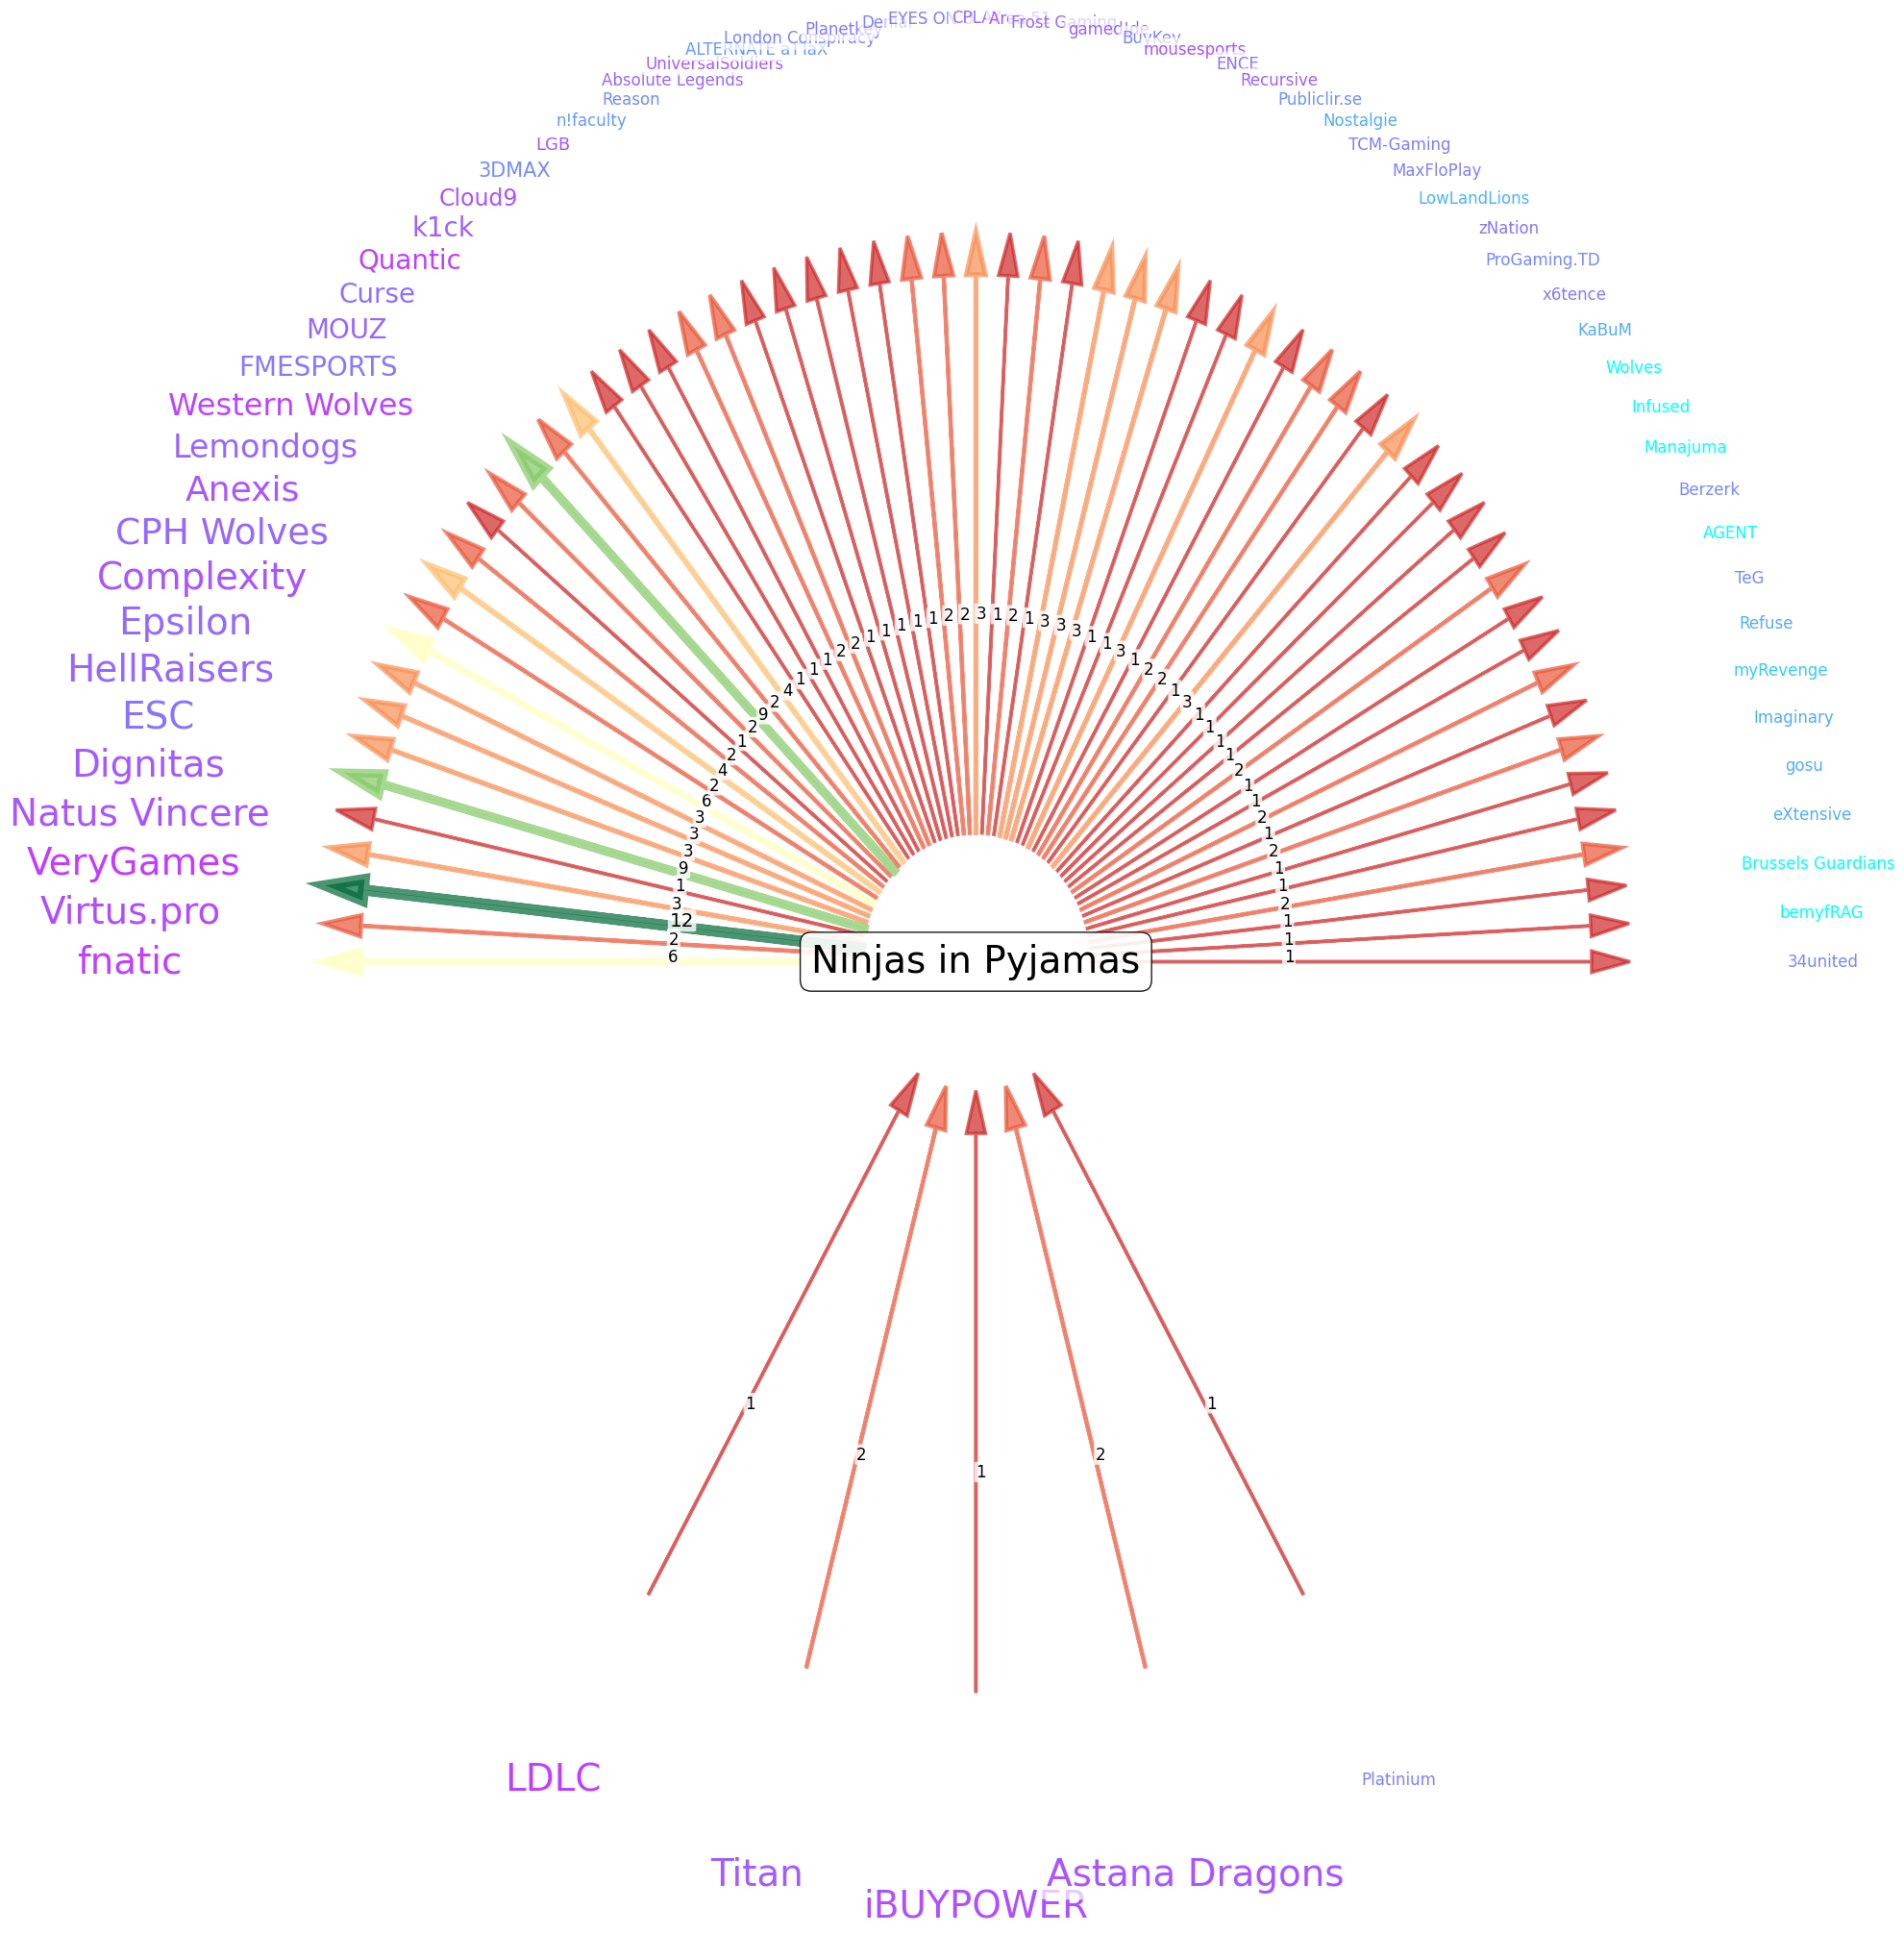

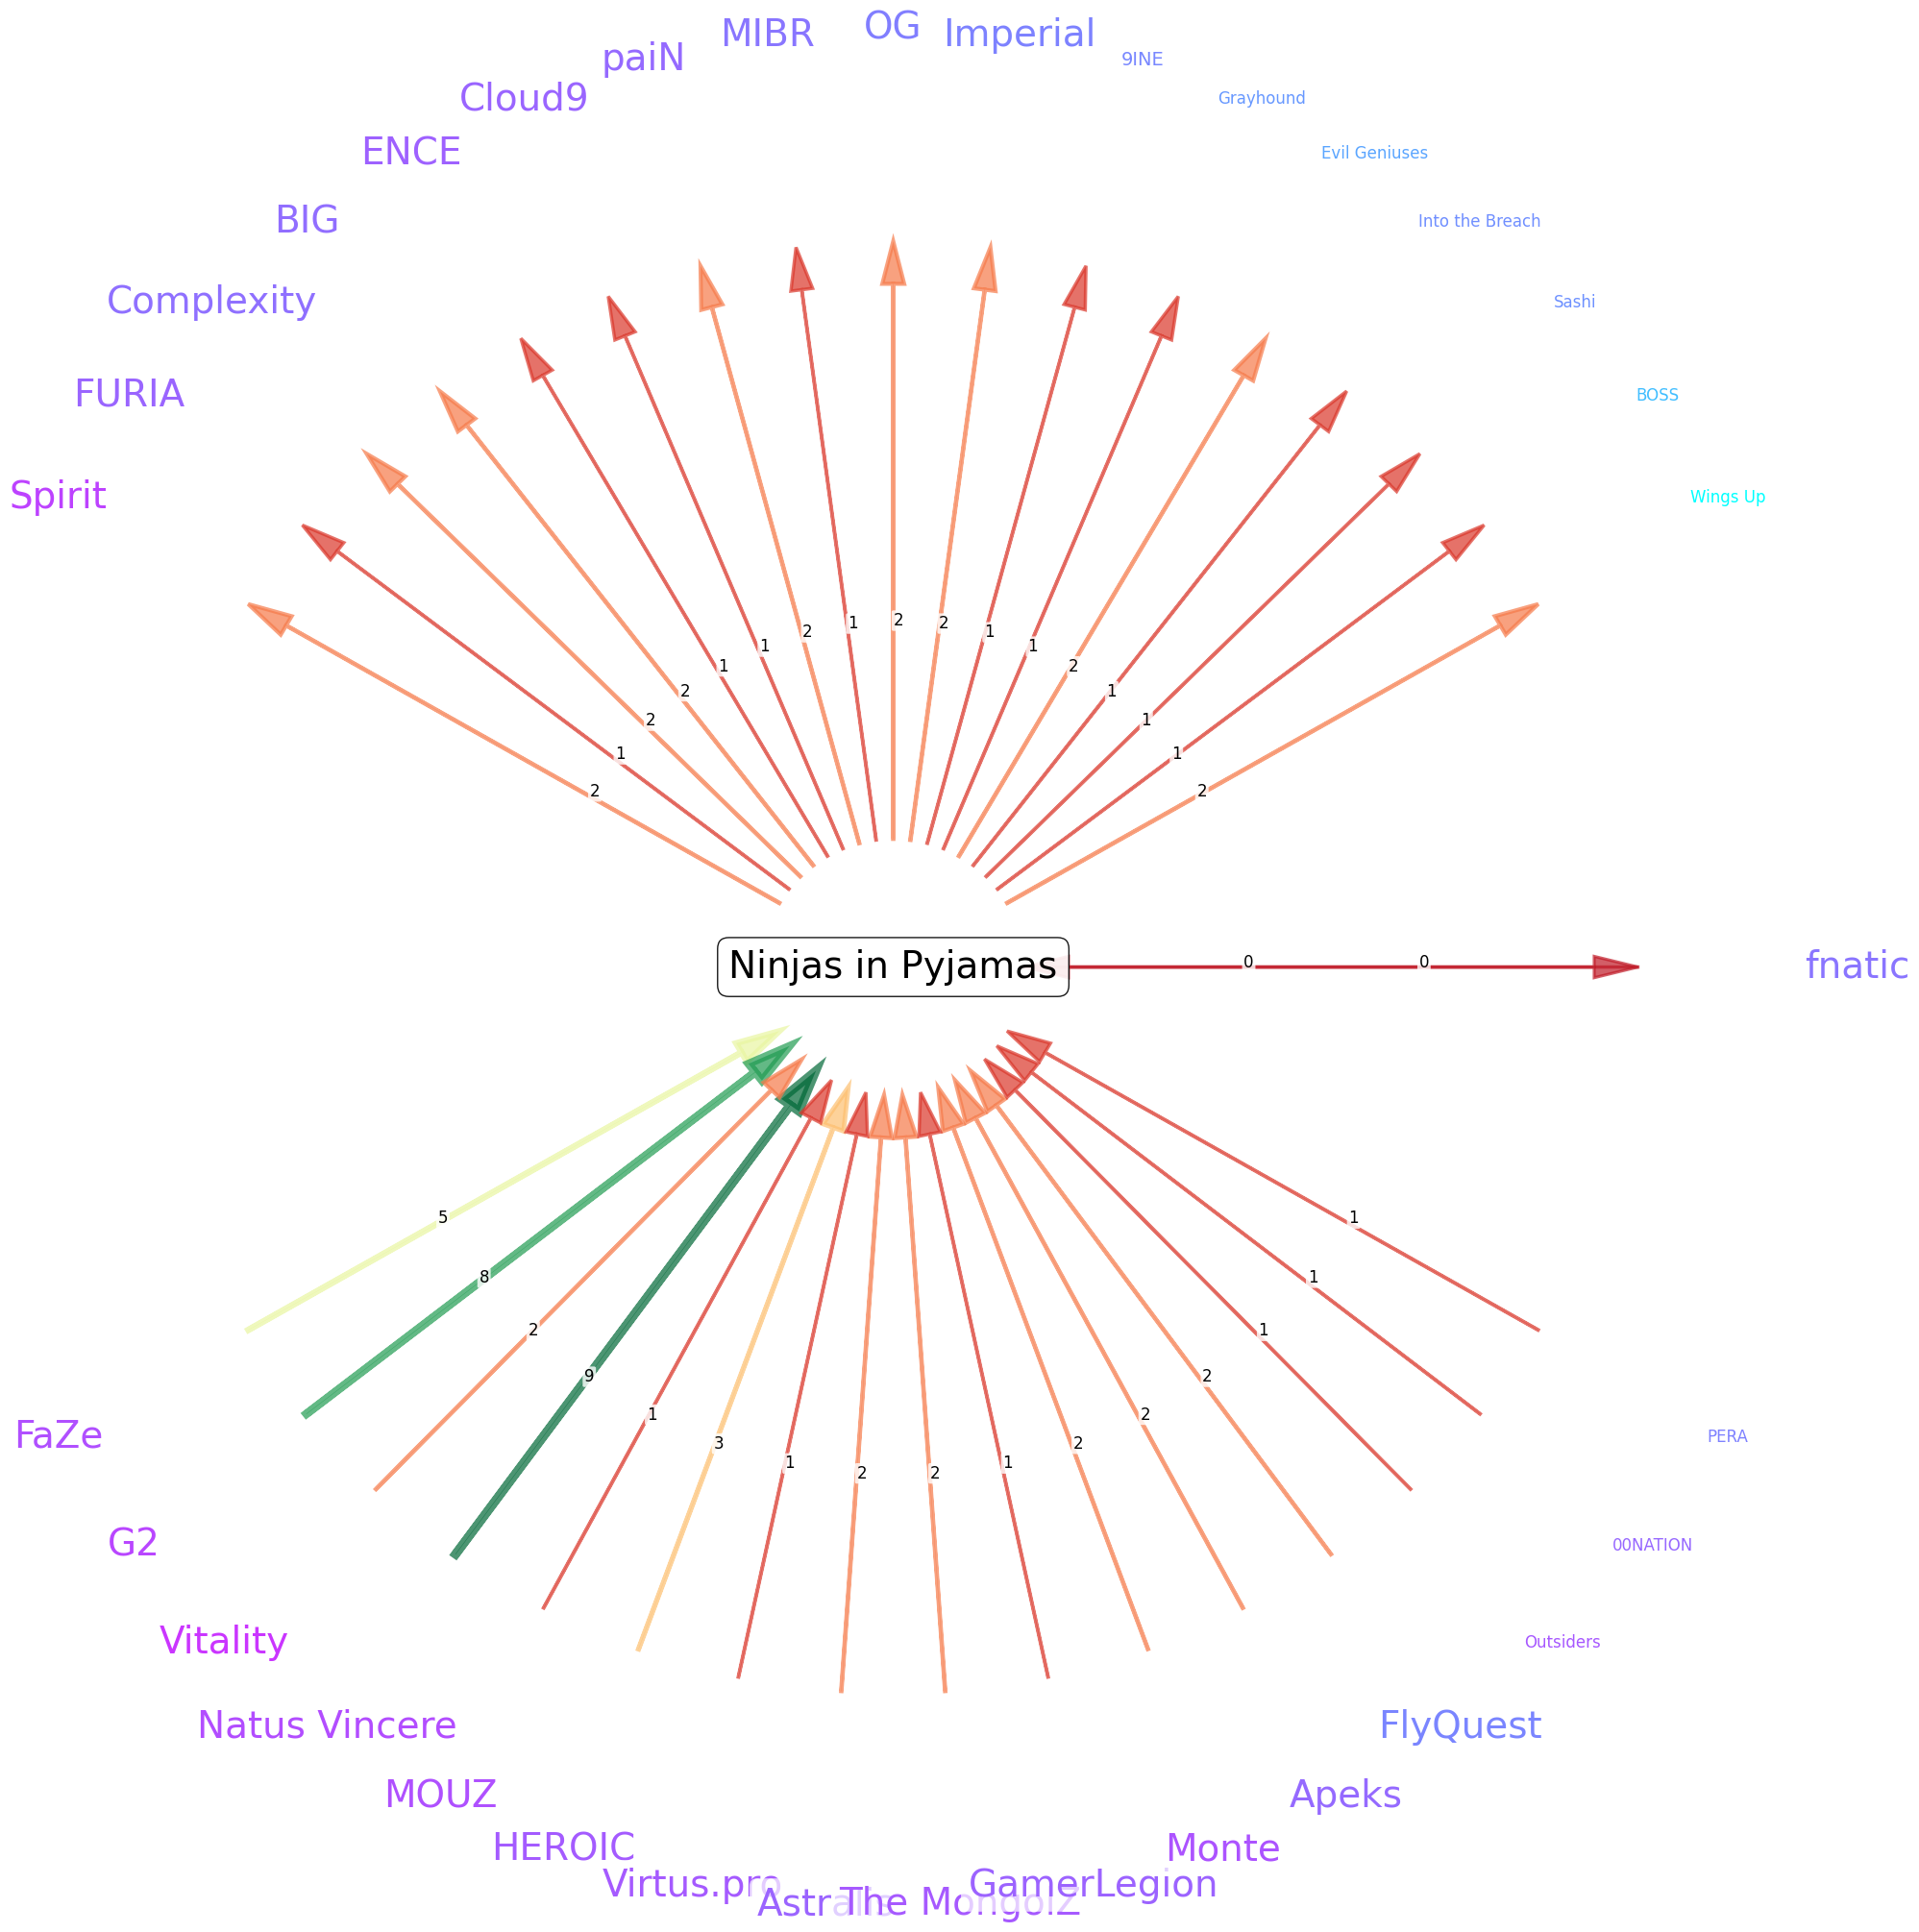

In [87]:
# Draw both
team="Ninjas in Pyjamas"
start_old, end_old = 2012, 2014
start_new, end_new = 2023, 2025
graph_2018_2019, nc_old = build_domination_graph(df,team, start_old, end_old)
graph_2023_2025, nc_new = build_domination_graph(df,team, start_new, end_new)
draw_graph(graph_2018_2019,team, nc_old, f"{team} Domination Graph ({start_old}-{end_old})")
draw_graph(graph_2023_2025,team, nc_new, f"{team} Domination Graph ({start_new}-{end_new})", dominated_places=(5*np.pi/6, np.pi/6), dominated_by_places=(-5*np.pi/6, -np.pi/6), tied_places=(0,0))

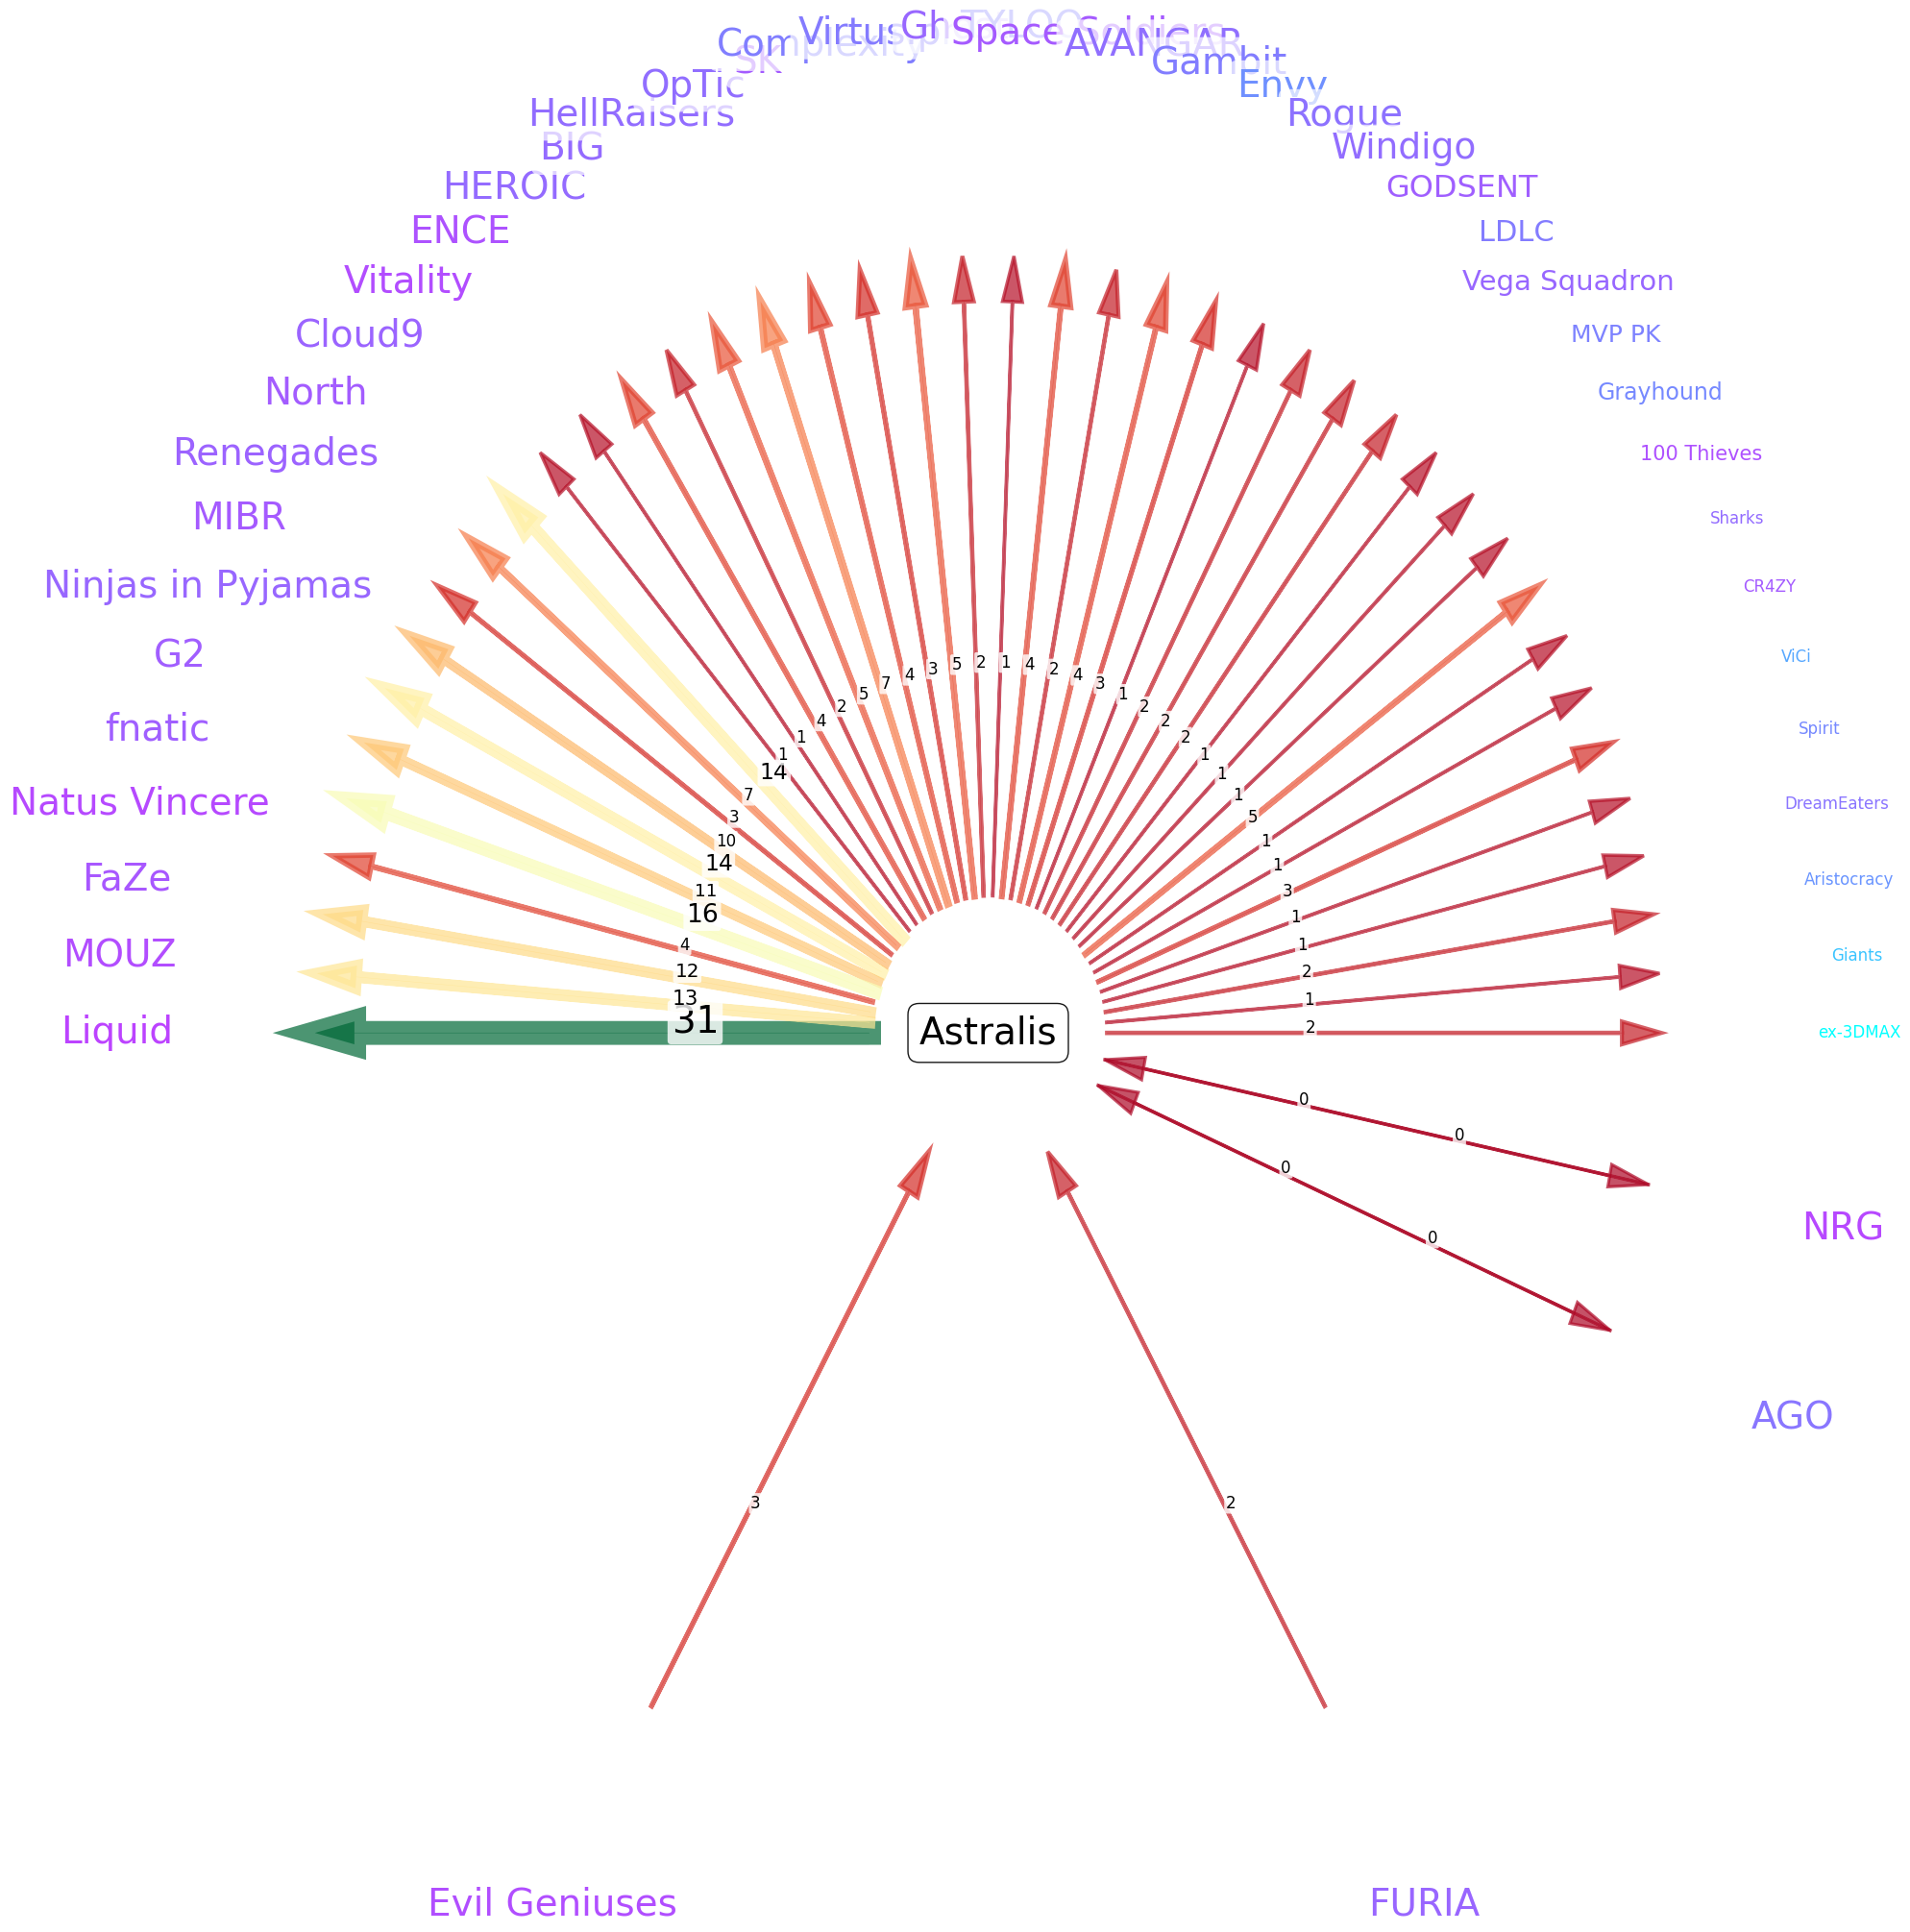

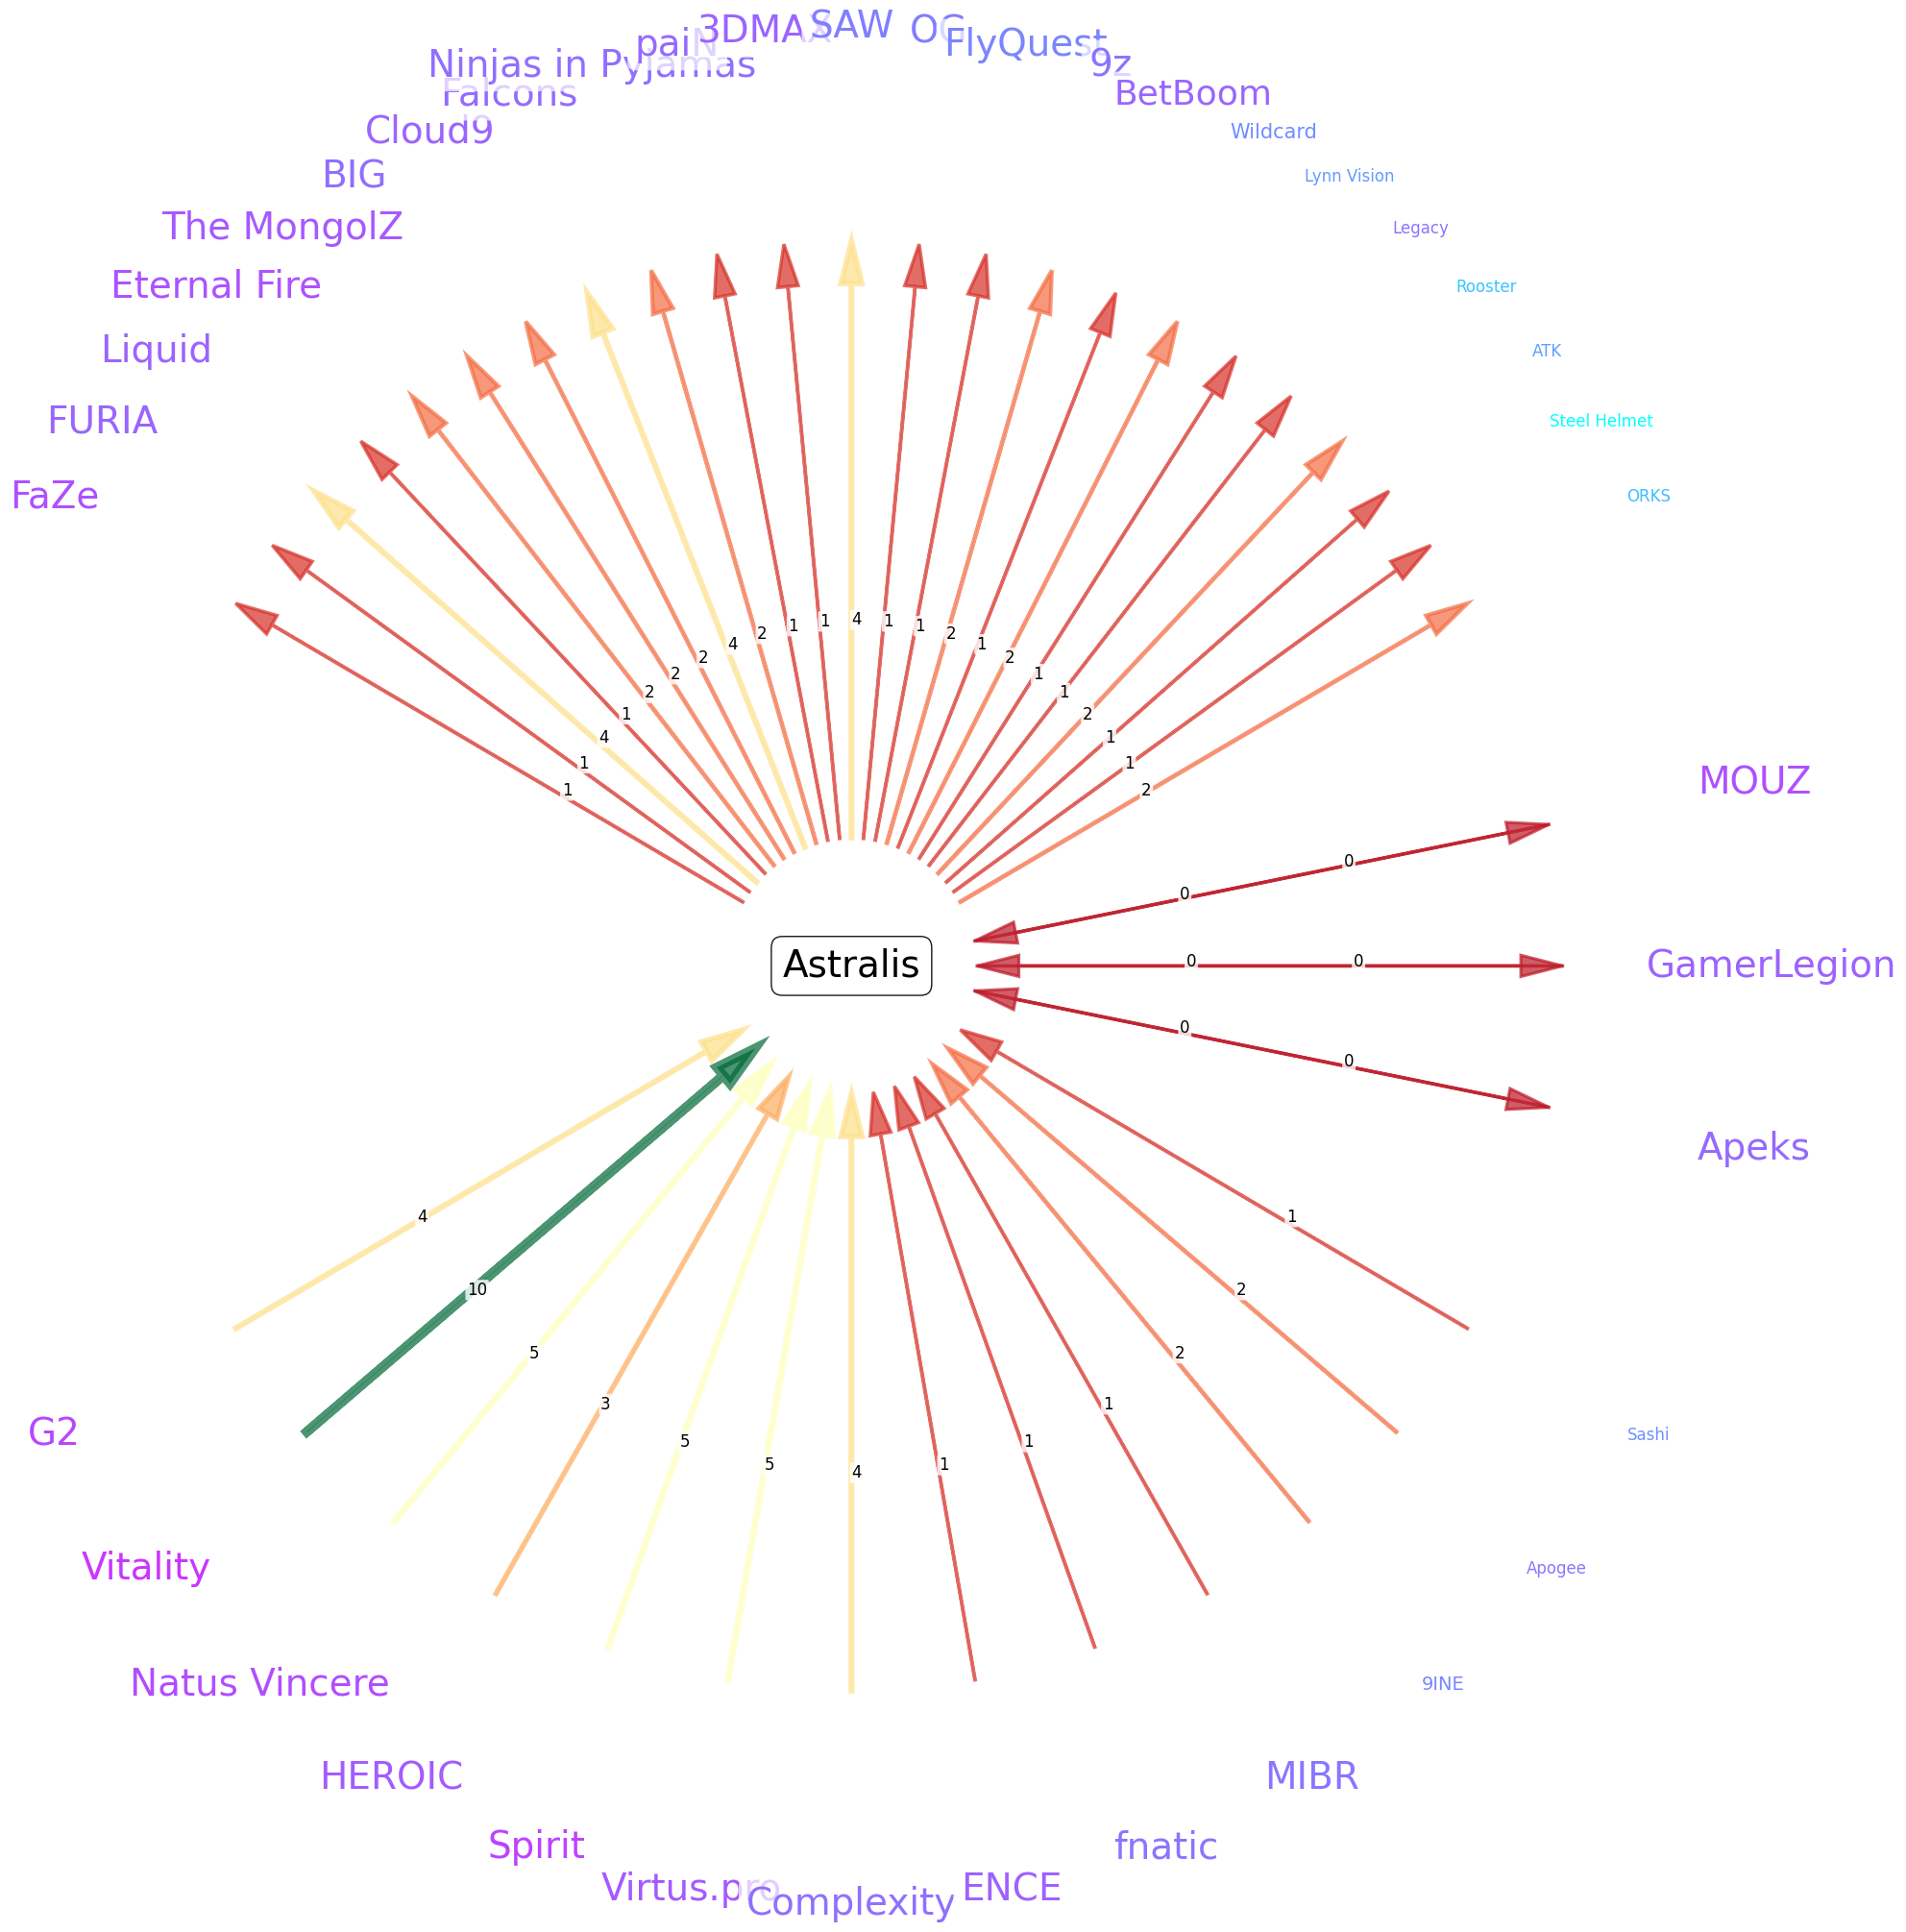

In [88]:
# Draw both
team="Astralis"
start_old, end_old = 2018, 2019
start_new, end_new = 2023, 2025
graph_2018_2019, nc_old = build_domination_graph(df,team, start_old, end_old)
graph_2023_2025, nc_new = build_domination_graph(df,team, start_new, end_new)
draw_graph(graph_2018_2019,team, nc_old, f"{team} Domination Graph ({start_old}-{end_old})", tied_places=(-np.pi/16,-np.pi/8 ))
draw_graph(graph_2023_2025,team, nc_new, f"{team} Domination Graph ({start_new}-{end_new})", dominated_places=(5*np.pi/6, np.pi/6), dominated_by_places=(-5*np.pi/6, -np.pi/6), tied_places=(np.pi/16, -np.pi/16))